# ◆Kickstarter Projects
### 目的：クラウドファンディングが成功するかを事前に予測する
### 目的変数をstateとする二値分類問題としてロジスティック回帰アルゴリズムを使ったモデルを構築する
- kaggle URL:https://www.kaggle.com/kemical/kickstarter-projects
- Create Date：2020/01/05　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 事前に予測できない項目は、除外する。
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル構築
- ロジスティック回帰モデルを利用する
- モデルパラメータ（重み）：$\mathbf{w} = (w_0, w_1, w_2, \dots, w_p)^{\mathrm{T}} $
- モデルへの入力：$\mathbf{x} = (1, x_1, x_2, \dots, x_p)^{\mathrm{T}} $
- 以上の2つが与えられたときのモデルの出力（確率値）：$\hat{Y}(\mathbf{x}; \mathbf{w}) =  f(\mathbf{w}^{\mathrm{T}} \mathbf{x})$
- $f$はシグモイド関数：$f(x) = \frac{1}{1 + \exp(-x)}$

### 4.モデル評価
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | ID| 識別ID | - | 不要と思われる為除外 |
|  2 | name |名称 | 欠損あり | ○※文字数を算出して利用 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日 | - | ○※期間算出 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使うため除外 |
|  8 | launched |開始日時 | - | ○※期間算出,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | 予測できないため除外 |
| 10 | state |プロジェクトの状態 | - | ◎※目的変数で利用（成功と失敗のみ抽出） |
| 11 | backers |支援者数 | - | 予測できないため除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | 予測できないため除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | 予測できないため除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler # 標準化

# ============================================================================
# 関数：成功と失敗別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    print('\n▼ ' + str(col_name) + 'の分布 ※歪度：',df[col_name].skew())
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['state']==0][col_name],kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(df[df['state']==1][col_name],kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：対数変換した成功と失敗別のヒストグラム
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram_log1p(col_name,w,h,bins_val):
    print('\n▼ 対数変換した' + str(col_name) + 'の分布')
    plt.figure(figsize=(w,h))
    sns.distplot(np.log1p(df[df['state']==0][col_name]),kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(np.log1p(df[df['state']==1][col_name]),kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name)
    plt.legend()
    plt.show()
    
# ============================================================================
# 関数：成功と失敗別に散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_scatter_plot(col_name, w, h):
    print('\n▼ ' + str(col_name) + 'の散布図')
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1.index, data1[col_name], 'o', color='C1', label='successful')
    plt.plot(data2.index, data2[col_name], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.ylabel(col_name)
    plt.xlabel('row_index')
    plt.show()

# ============================================================================
# 関数：成功数と失敗数別にカウント表示するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無、xラベルの回転
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False, x_rot = 0):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数（降順）')
        ax = sns.countplot(df[col_name],hue=df['state'],order = df[col_name].value_counts().index)
    else:
        print('\n▼ ' + str(col_name) + '別の成功数と失敗数')
        ax = sns.countplot(df[col_name],hue=df['state'])
        
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：成功率を棒グラフで比較するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無、xラベルの回転
# ============================================================================
def show_successrate_barplot(col_name, w, h, baseline, sort_flg=False, x_rot = 0):
    # stateの平均値が成功率になる（成功率＝成功の件数/全体の件数）
    successrate = pd.DataFrame(df['state'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('state', ascending=False) # 成功率の降順
        print('\n▼ ' + str(col_name) + '別の成功率（降順）※赤線：学習データの平均成功率')
    else:
        print('\n▼ ' + str(col_name) + '別の成功率 ※赤線：学習データの平均成功率')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="state", data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('Success rate by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.show()

## 1.データ読込

In [2]:
# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

print("\n▼ 先頭5行表示")
display(df.head(5))

print("\n▼ 基本統計量")
display(df.describe())

print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))


▼ 先頭5行表示


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00



▼ 基本統計量


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08



▼ 欠損データ確認


,Missing num
name,4
usd pledged,3797


## 2.データ前処理
### 2-1.説明変数の選定


▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化


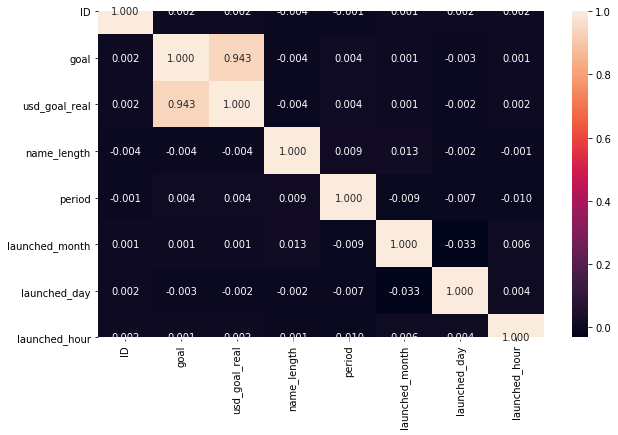

→goalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。


In [3]:
# ****************************************************************************
# ◆ 2.前処理
# ****************************************************************************
# ------------------------------------------------
# 2-1.説明変数の選定
# ------------------------------------------------

# 事前に予測できない項目を削除
df = df.drop(['backers'], axis=1)          # 集客数は事前に予測できない為、除外
df = df.drop(['pledged'], axis=1)          # 集まった資金は事前に予測できない為、除外
df = df.drop(['usd pledged'], axis=1)      # 欠損があり、集まった資金は事前に予測できない為、除外
df = df.drop(['usd_pledged_real'], axis=1) # 集まった資金は事前に予測できない為、除外

# 説明変数になりそうな項目を追加
df['name_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', ''))) # nameの文字数
df['period'] = (df['deadline'] - df['launched']).dt.days  # 開始日時と終了日から期間を算出
df['launched_month'] = df['launched'].dt.month            # 開始時期の月に着目
df['launched_day'] = df['launched'].dt.day                # 開始時期の日に着目
df['launched_hour'] = df['launched'].dt.hour              # 開始時期の時間に着目

#print("\n▼ 先頭5行表示")
#display(df.head(5))

## 散布図行列
#plt.figure(figsize=(6,6))
#sns.pairplot(df, hue="state")
#plt.show()

# ヒートマップ
print('\n▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()

print('→goalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。')

# 説明変数にはならなそうな項目を除外
df = df.drop(['ID'], axis=1)               # 不要と考え除外
df = df.drop(['name'], axis=1)             # 欠損があり、説明変数にするには難しいと思われるので除外
df = df.drop(['goal'], axis=1)             # usd_goal_realとほぼ等しい為、除外

# 抽出元の不要な項目を削除
df = df.drop(['launched'], axis=1)
df = df.drop(['deadline'], axis=1)

### 2-2.目的変数の前処理


▼ 目的変数 stateの種類（%）


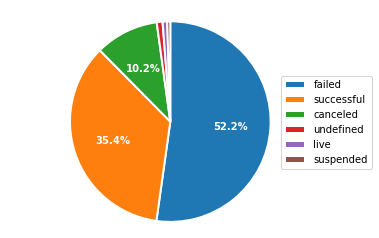

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。

▼ stateが成功または失敗のデータを抽出


,state
failed,197719
successful,133956



▼ 成功率の平均値
baseline= 0.4038772895153388


In [4]:
# ------------------------------------------------
# 2-2.目的変数（state）の前処理
# ------------------------------------------------
print('\n▼ 目的変数 stateの種類（%）')
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

# stateが成功または失敗のデータを抽出
df = df.query('state in ["successful", "failed"]')

print('\n▼ stateが成功または失敗のデータを抽出')
display(pd.DataFrame(df['state'].value_counts(),columns=['state']))

# 変換（成功=1，失敗=0）
df['state'] = df['state'].map({'failed': 0,'successful': 1})

# 成功率の平均
print('\n▼ 成功率の平均値')
baseline = df['state'].mean()
print('baseline=',baseline)


### 2-3.説明変数の確認


▼ periodの分布 ※歪度： 1.2535940368557628


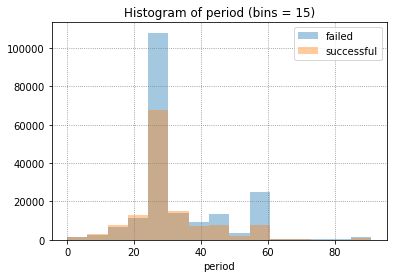

→失敗よりも成功が多い期間がある。

▼ period別の成功数と失敗数


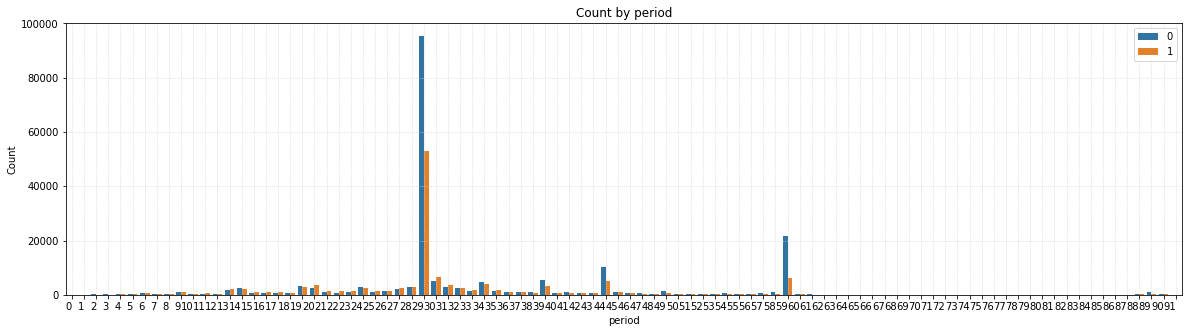

→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。

▼ period別の成功率 ※赤線：学習データの平均成功率


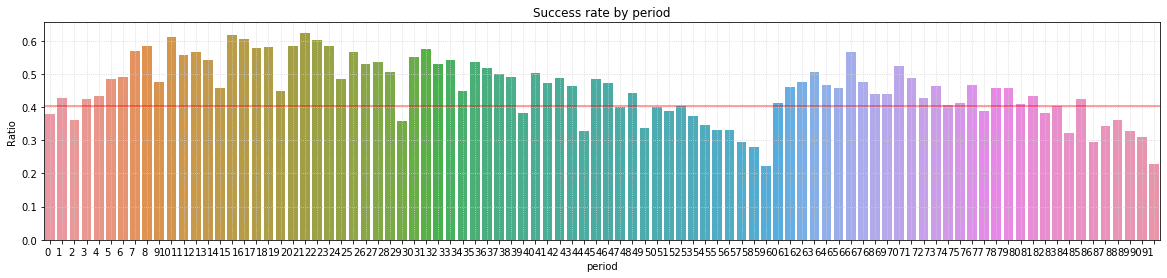

→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。


In [5]:
# ------------------------------------------------
# 2-3-1.期間（日数）
# ------------------------------------------------
show_histogram('period',6,4,15)
print('→失敗よりも成功が多い期間がある。')

# 期間(日数)の分布を確認
show_state_count_plot('period',20,5)
print('→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。')

# 期間(日数)別の成功率を確認
show_successrate_barplot("period",20,4,baseline,False)
print('→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。')


▼ usd_goal_realの散布図


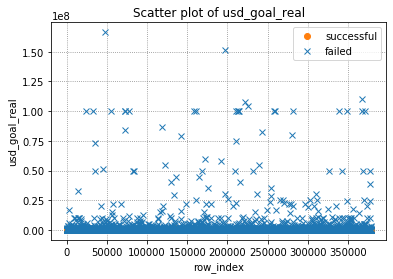

→目標金額が高すぎるものは、失敗している。

▼ usd_goal_realの分布 ※歪度： 83.10938853908664


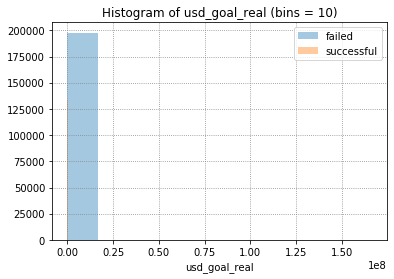

→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する

▼ 対数変換したusd_goal_realの分布


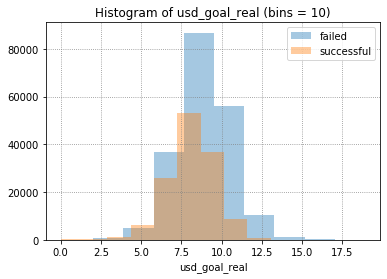

→全体的に目標金額が高くなると失敗しやすくなりそう。


In [6]:
# ------------------------------------------------
# 2-3-2.目標金額
# ------------------------------------------------
# 外れ値がないか散布図で確認
show_scatter_plot('usd_goal_real',6,4)
print('→目標金額が高すぎるものは、失敗している。')
# 目標金額の分布
show_histogram('usd_goal_real',6,4,10)
print('→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する')
show_histogram_log1p('usd_goal_real',6,4,10)
print('→全体的に目標金額が高くなると失敗しやすくなりそう。')


▼ launched_month別の成功数と失敗数


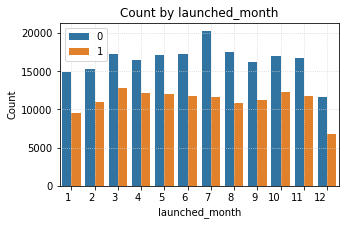


▼ launched_month別の成功率 ※赤線：学習データの平均成功率


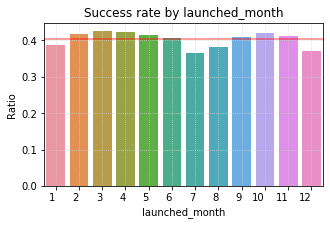

→春と秋あたりに開始すると成功率が若干高まる。

▼ launched_day別の成功数と失敗数


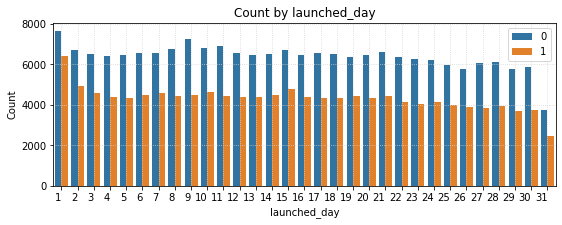


▼ launched_day別の成功率 ※赤線：学習データの平均成功率


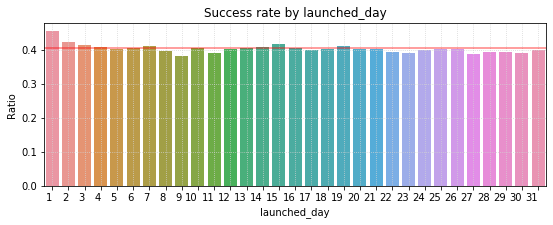

→月の上旬（特に1日開始）の成功率が若干高い。

▼ launched_hour別の成功数と失敗数


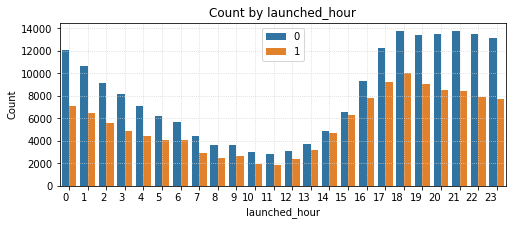


▼ launched_hour別の成功率 ※赤線：学習データの平均成功率


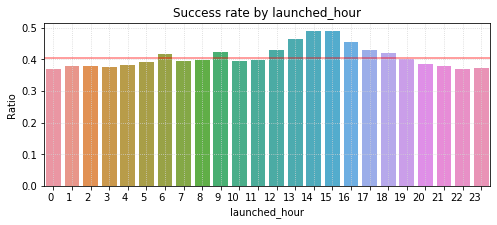

→午後2,3時あたりに開始すると成功率が高まるようだ。


In [7]:
# ------------------------------------------------
# 2-3-3.開始時期（月、日、時間）
# ------------------------------------------------
show_state_count_plot('launched_month',5,3)
show_successrate_barplot('launched_month',5,3,baseline)
print('→春と秋あたりに開始すると成功率が若干高まる。')

show_state_count_plot('launched_day',9,3)
show_successrate_barplot("launched_day",9,3,baseline)
print('→月の上旬（特に1日開始）の成功率が若干高い。')

show_state_count_plot('launched_hour',8,3)
show_successrate_barplot("launched_hour",8,3,baseline)
print('→午後2,3時あたりに開始すると成功率が高まるようだ。')


▼ main_categoryとcategory別のカウントと成功率


state          
                              count      mean
main_category category                       
Art           Art              7486  0.452177
              Ceramics          275  0.480000
              Conceptual Art    930  0.393548
              Digital Art      1171  0.316823
              Illustration     2890  0.562630
              Installations     436  0.534404
              Mixed Media      2513  0.376045
              Painting         3035  0.378583
              Performance Art  1974  0.473151
              Public Art       2850  0.541404
...                             ...       ...
Technology    Wearables         967  0.401241
              Web              3237  0.079703
Theater       Comedy             92  0.663043
              Experimental      342  0.616959
              Festivals         512  0.630859
              Immersive         297  0.569024
              Musical           830  0.556627
              Plays            1291  0.622773
              Spaces            194  0.510309
              Theater          6684  0.659037

[170 rows x 2 columns]

→main_categoryとcategoryは別々で考慮したほうが良さそう。

▼ main_category別の成功数と失敗数（降順）


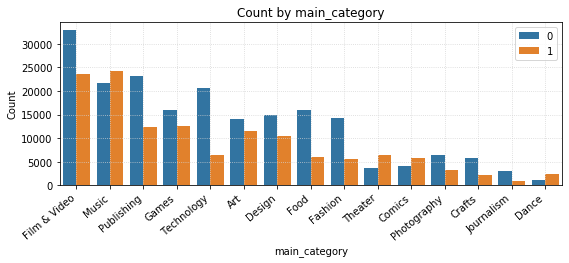


▼ main_category別の成功率（降順）※赤線：学習データの平均成功率


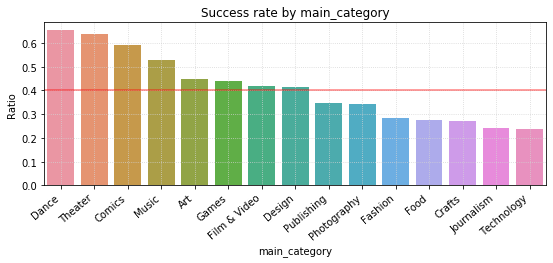

→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。

▼ category別の成功数と失敗数（降順）


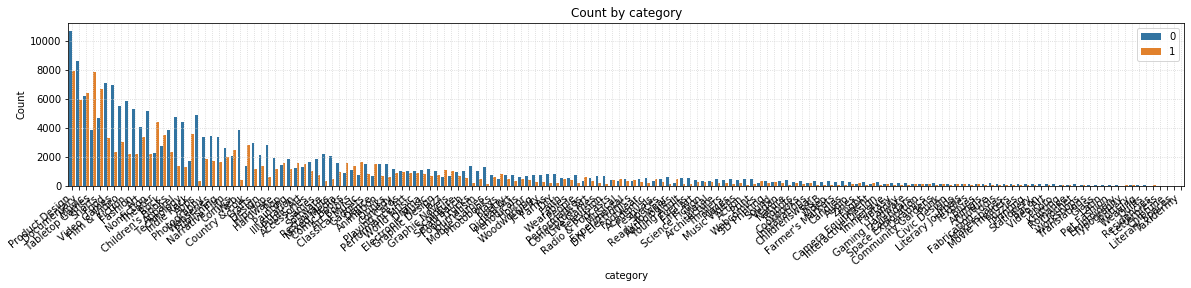

▼ category件数順（Top10）


,category
Product Design,18680
Documentary,14523
Music,12633
Tabletop Games,11744
Shorts,11394
Food,10416
Video Games,9328
Film & Video,8624
Fiction,8108
Fashion,7529



▼ category別の成功率（降順）※赤線：学習データの平均成功率


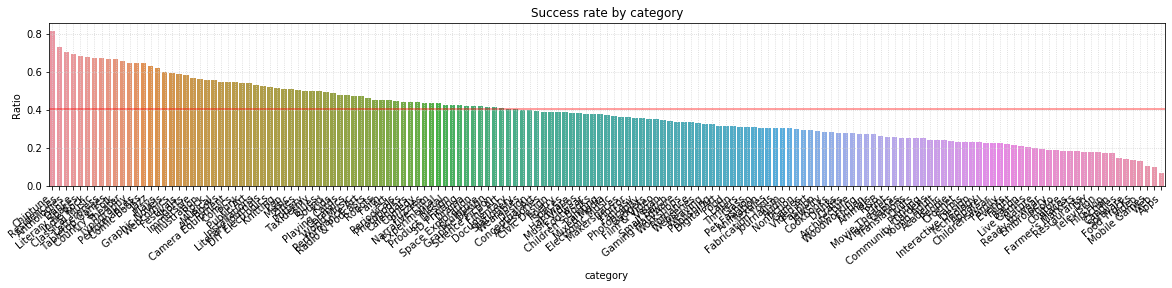

▼ category成功率順（Top10）


,state
category,
Chiptune,0.818182
Residencies,0.735294
Anthologies,0.706920
Dance,0.695221
Literary Spaces,0.684211
Indie Rock,0.678927
Classical Music,0.675000
Letterpress,0.673913
Tabletop Games,0.669789


→成功しやすいcategoryと失敗しやすいcategoryがありそう。


In [8]:
# ------------------------------------------------
# 2-3-4.主なカテゴリとカテゴリ
# ------------------------------------------------
# main_categoryとcategoryの関係
print('\n▼ main_categoryとcategory別のカウントと成功率')
df_category = df[['main_category','category','state']]

pd.set_option('display.max_rows', 20)

display(df_category.groupby(['main_category', 'category']).agg(['count','mean']))
print('→main_categoryとcategoryは別々で考慮したほうが良さそう。')

# main_category
show_state_count_plot('main_category',9,3, True,40)
show_successrate_barplot('main_category',9,3, baseline,True,40)
print('→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。')

# category
show_state_count_plot('category',20,3, True,40)

print('▼ category件数順（Top10）')
display(pd.DataFrame(df['category'].value_counts(),columns=['category']).head(10))

show_successrate_barplot('category',20,3, baseline,True,40)

print('▼ category成功率順（Top10）')
successrate = pd.DataFrame(df['state'].groupby(df['category']).mean())
successrate_s = successrate.sort_values('state', ascending=False) # 成功率降順
display(successrate_s.head(10))

print('→成功しやすいcategoryと失敗しやすいcategoryがありそう。')



▼ currencyとcountry別のカウントと成功率


state          
                   count      mean
currency country                  
AUD      AU         6616  0.303809
         N,0"          5  0.200000
CAD      CA        12370  0.334196
         N,0"          5  0.600000
CHF      CH          652  0.286810
DKK      DK          926  0.388769
         N,0"          3  0.666667
EUR      AT          485  0.220619
         BE          523  0.290631
         DE         3436  0.272701
         ES         1873  0.262680
         FR         2520  0.360317
         IE          683  0.303075
         IT         2369  0.185310
         LU           57  0.333333
         N,0"         21  0.190476
         NL         2411  0.255910
GBP      GB        29454  0.409690
         N,0"         22  0.636364
HKD      HK          477  0.452830
JPY      JP           23  0.304348
MXN      MX         1411  0.280652
NOK      N,0"          2  0.500000
         NO          582  0.278351
NZD      NZ         1274  0.351648
SEK      N,0"          1  0.000000
         SE         1509  0.337309
SGD      SG          454  0.392070
USD      N,0"        151  0.529801
         US       261360  0.418193

→country=N,0"について、除外するかcurrencyから想定できるcountryにするかどうか検討する。

▼ currency別の成功数と失敗数（降順）


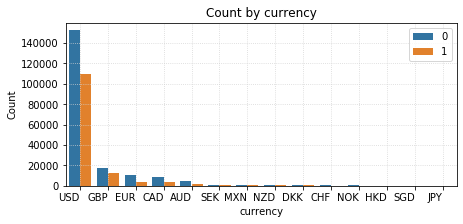


▼ currency別の成功率（降順）※赤線：学習データの平均成功率


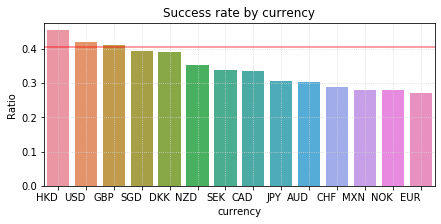


▼ country別の成功数と失敗数（降順）


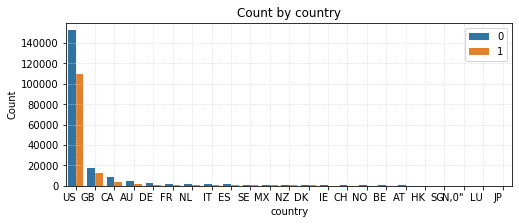


▼ country別の成功率（降順）※赤線：学習データの平均成功率


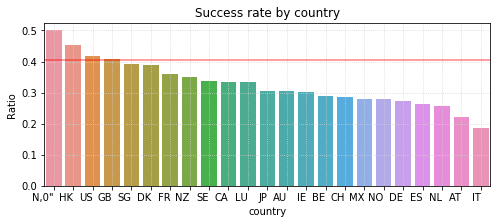

→currencyとcountryは関連しているので、どちらか一方でよいかも。


In [9]:
# ------------------------------------------------
# 2-3-5.currencyとcountry
# ------------------------------------------------
# currencyとcountryの関係を確認
print('\n▼ currencyとcountry別のカウントと成功率')
pd.set_option('display.max_rows', 30)
df_currency = df[['currency','country','state']]
display(df_currency.groupby(['currency','country']).agg(['count','mean']))

print('→country=N,0\"について、除外するかcurrencyから想定できるcountryにするかどうか検討する。')
#print(df["country"].where(df['country'] == 'N,0"').value_counts())
#df = df[(df['country'] != 'N,0"')]

# currency
show_state_count_plot('currency',7,3,True)
show_successrate_barplot('currency',7,3,baseline,True)

# country
show_state_count_plot('country',8,3,True)
show_successrate_barplot('country',8,3,baseline,True)

print('→currencyとcountryは関連しているので、どちらか一方でよいかも。')



▼ name_lengthの分布 ※歪度： 0.12789205186789132


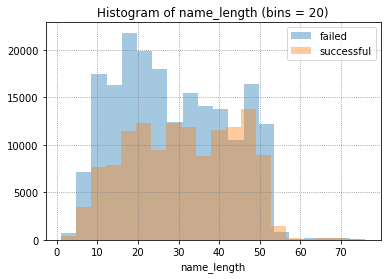

→文字数が少ないと失敗しやすいように見える。

▼ name_length別の成功数と失敗数


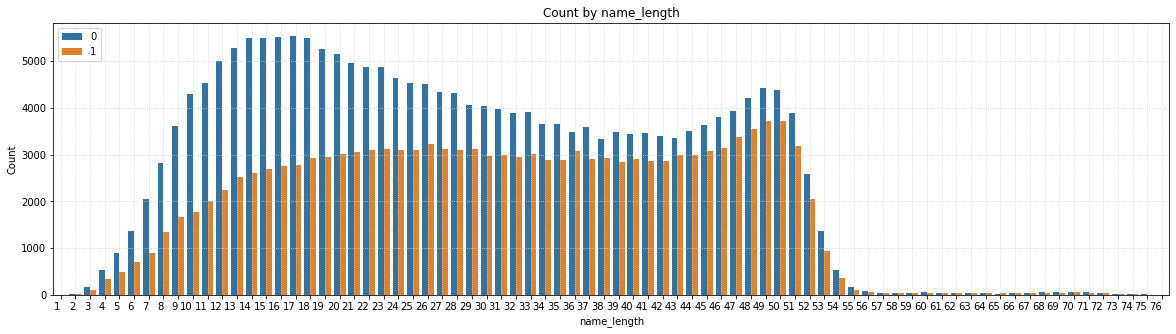


▼ name_length別の成功率 ※赤線：学習データの平均成功率


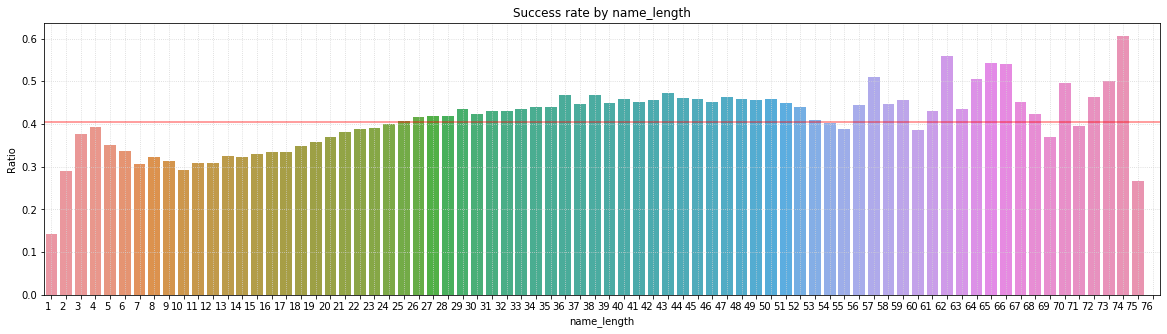

→若干は、成功しやすさの要因になると考えられる。


In [10]:
# ------------------------------------------------
# 2-3-6.name_length
# ------------------------------------------------
show_histogram('name_length',6,4,20)
print('→文字数が少ないと失敗しやすいように見える。')
show_state_count_plot('name_length',20,5)
show_successrate_barplot('name_length',20,5,baseline)
print('→若干は、成功しやすさの要因になると考えられる。')

### 2-4.ヒートマップ表示


▼ stateと説明変数（数値項目）の相関関係を確認


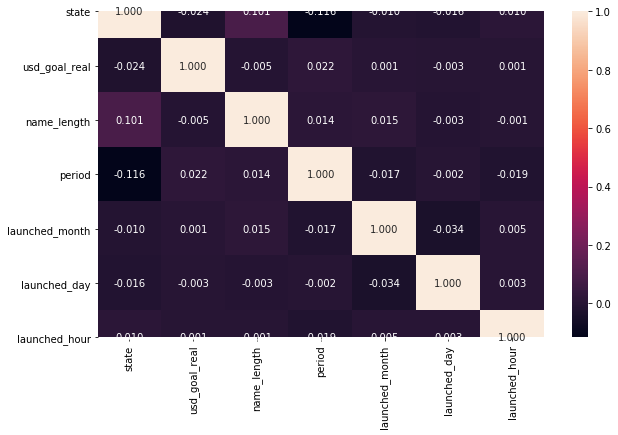

→stateとname_lengthの相関関係が他より高いことが分かる。


In [11]:
# ------------------------------------------------
# 2-4.stateとの相関係数を確認
# ------------------------------------------------
print('\n▼ stateと説明変数（数値項目）の相関関係を確認')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f')
plt.show()

print('→stateとname_lengthの相関関係が他より高いことが分かる。')

### 2-5.ダミー変換

In [18]:
# ------------------------------------------------
# 2-5.ダミー変換
# ------------------------------------------------
# one-hot-encoding
df_dummies = pd.get_dummies(df, columns=['main_category','category','country','currency',
                                         'launched_month','launched_day','launched_hour','period'])


# main_categoryとcategoryの相関チェック→遅すぎてでかすぎる
#df_chk_d1 = pd.get_dummies(df[['state','main_category','category']], columns=['main_category','category'])
#print('\n▼ stateとmain_categoryとcategoryの相関関係を確認')
#plt.figure(figsize=(20,20))
#sns.heatmap(df_chk_d1.corr())
#plt.show()

# currencyとccountoryの相関チェック→遅すぎてでかすぎる
#df_chk_d2 = pd.get_dummies(df[['state','currency','country']], columns=['currency','country'])
#print('\n▼ stateとcurrencyとcountryの相関関係を確認')
#plt.figure(figsize=(20,20))
#sns.heatmap(df_chk_d2.corr())
#plt.show()

# 標準化
scaler = StandardScaler()        
df_dummies['usd_goal_real'] = scaler.fit_transform(df_dummies.loc[:, ['usd_goal_real']])
df_dummies['name_length'] = scaler.fit_transform(df_dummies.loc[:, ['name_length']])

print('\n▼ 説明変数の数')
print(len(df_dummies.drop('state', axis=1).columns))

print('\n▼ 先頭5行表示')
pd.set_option('display.max_columns', 500)
display(df_dummies.head(5))

C:\Users\arsma\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\arsma\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)



▼ 説明変数の数
372

▼ 先頭5行表示


,state,usd_goal_real,name_length,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Literary Spaces,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_Quilts,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Residencies,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Taxidermy,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,launched_month_1,launched_month_2,launched_month_3,launched_month_4,launched_month_5,launched_month_6,launched_month_7,launched_month_8,launched_month_9,launched_

## 3.モデル構築


▼ 重みを表示（絶対値の降順：Top10）


,feature,weight
0,usd_goal_real,-24.514535
1,period_80,-5.320713
2,period_85,2.255295
3,category_Video,-1.765734
4,category_Hip-Hop,-1.521057
5,category_Letterpress,1.502489
6,category_Residencies,1.436361
7,category_Web,-1.427454
8,category_Apps,-1.410311
9,category_Photo,-1.362486



▼ 重みの大きさを横棒グラフで表示


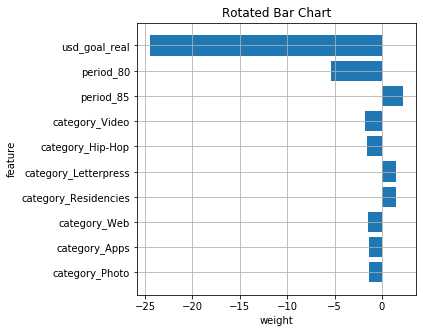

In [19]:
# ****************************************************************************
# ◆ 3.モデル構築
# ****************************************************************************
# ------------------------------------------------
# 3-1.モデルを生成して学習する  
# ------------------------------------------------
X = df_dummies.drop('state', axis=1).values # 説明変数
y = df_dummies['state'].values              # 目的変数

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(df_dummies.drop('state', axis=1).columns)
res_df['weight'] = np.reshape(clf.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
print('\n▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
print('\n▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(5, 5))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()


## 4.モデル評価

In [20]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************
# ------------------------------------------------
# 4-1.モデル検証  
# ------------------------------------------------
y_est = clf.predict(X)

#print('\n▼ モデルの予測結果(先頭10件)')
#print(y_est[:11])

# 予測確率を出力
#print('\n▼ 結果の予測確率(先頭10件)\n(失敗する確率：成功する確率):')
#print(clf.predict_proba(X)[:11].astype(float))

# ------------------------------------------------
# 4-2.モデル評価結果
# ------------------------------------------------
print('\n▼ モデルの評価結果')

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])

display(conf_mat)


▼ モデルの評価結果
対数尤度 = -10.971
正答率 = 68.236%
適合率（Precision※精度) = 69.810%
再現率（Recall※検出率) = 82.313%
F1値（F1-score） = 75.548%

▼ 混同行列


,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,162748,34971
正解 = 資金調達成功,70382,63574


### 気になること
- 対数尤度は、大きいほど精度がよい認識だが、プラスに転じることはあるか。
- ロジスティック回帰のような二値分類問題において重みのプラスとマイナスについて、それぞれに意味はあるのか。
- 数値項目でもダミー変換してよかったかどうか。例）期間、開始月、日、時間
- ヒートマップ以外で数値項目でない項目同士の相関関係をみる方法はあるか。例）main_categoryとcategory、currencyとcountry
- 関連項目は、どちらか一方を利用することを検討すべきだろうか。例）main_categoryとcategory、currencyとcountry